<a href="https://colab.research.google.com/github/archie46/Machine-Learning-/blob/main/BreastCancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import tempfile
import os
# Preset matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]
print(tf.__version__)
# To make the results reproducible, set the random seed value.
tf.random.set_seed(22)

2.9.2


In [ ]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data'
features = ['radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness',
'concavity', 'concave_poinits', 'symmetry', 'fractal_dimension']
column_names = ['id', 'diagnosis']
for attr in ['mean', 'ste', 'largest']:
  for feature in features:
    column_names.append(feature + "_" + attr)

In [ ]:
dataset = pd.read_csv(url, names=column_names)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         699 non-null    int64  
 1   diagnosis                  699 non-null    int64  
 2   radius_mean                699 non-null    int64  
 3   texture_mean               699 non-null    int64  
 4   perimeter_mean             699 non-null    int64  
 5   area_mean                  699 non-null    int64  
 6   smoothness_mean            699 non-null    object 
 7   compactness_mean           699 non-null    int64  
 8   concavity_mean             699 non-null    int64  
 9   concave_poinits_mean       699 non-null    int64  
 10  symmetry_mean              699 non-null    int64  
 11  fractal_dimension_mean     0 non-null      float64
 12  radius_ste                 0 non-null      float64
 13  texture_ste                0 non-null      float64

In [ ]:
dataset.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_poinits_mean,...,radius_largest,texture_largest,perimeter_largest,area_largest,smoothness_largest,compactness_largest,concavity_largest,concave_poinits_largest,symmetry_largest,fractal_dimension_largest
0,1000025,5,1,1,1,2,1,3,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1002945,5,4,4,5,7,10,3,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1015425,3,1,1,1,2,2,3,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1016277,6,8,8,1,3,4,3,7,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1017023,4,1,1,3,2,1,3,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
train_dataset = dataset.sample(frac=0.75, random_state=1)
len(train_dataset)
test_dataset = dataset.drop(train_dataset.index)
len(test_dataset)

175

In [ ]:
y_train, y_test = y_train.map({'B': 0, 'M': 1}), y_test.map({'B': 0, 'M': 1})
x_train, y_train = tf.convert_to_tensor(x_train, dtype=tf.float32), tf.convert_to_tensor(y_train,
dtype=tf.float32)
x_test, y_test = tf.convert_to_tensor(x_test, dtype=tf.float32), tf.convert_to_tensor(y_test,
dtype=tf.float32)

NameError: ignored

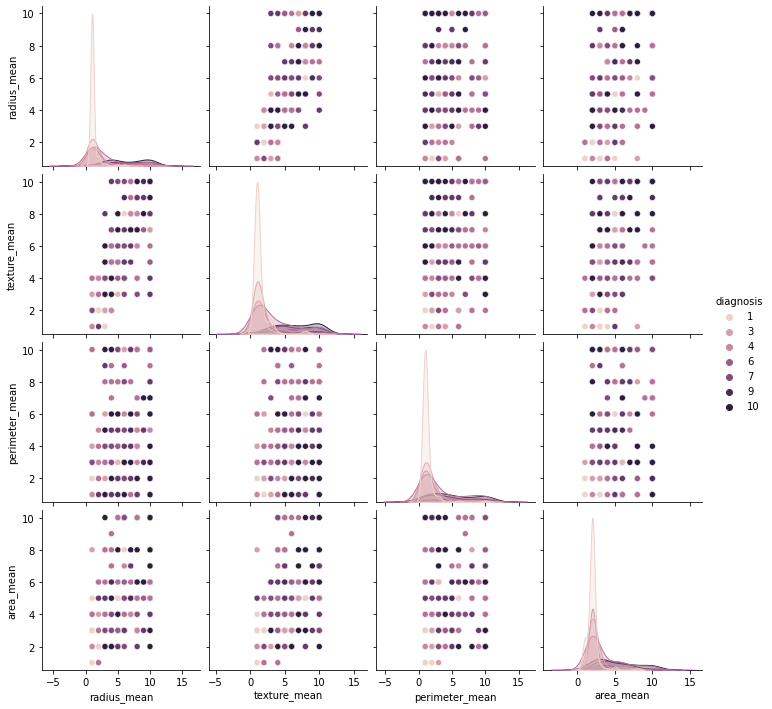

In [ ]:
sns.pairplot(train_dataset.iloc[:, 1:6], hue = 'diagnosis', diag_kind='kde');

In [ ]:
train_dataset.describe().transpose()[:10]

,count,mean,std,min,25%,50%,75%,max
id,524.0,1.077908e+06,691219.929022,63375.0,849831.25,1169734.0,1234867.25,13454352.0
diagnosis,524.0,4.450382e+00,2.871935,1.0,2.00,4.0,6.00,10.0
radius_mean,524.0,3.156489e+00,3.089849,1.0,1.00,1.0,5.00,10.0
texture_mean,524.0,3.288168e+00,3.042556,1.0,1.00,1.0,5.00,10.0
perimeter_mean,524.0,2.811069e+00,2.885414,1.0,1.00,1.0,4.00,10.0
area_mean,524.0,3.232824e+00,2.229472,1.0,2.00,2.0,4.00,10.0
compactness_mean,524.0,3.459924e+00,2.482119,1.0,2.00,3.0,4.25,10.0
concavity_mean,524.0,2.875954e+00,3.077997,1.0,1.00,1.0,4.00,10.0
concave_poinits_mean,524.0,1.624046e+00,1.791704,1.0,1.00,1.0,1.00,10.0
symmetry_mean,524.0,2.698473e+00,0.954369,2.0,2.00,2.0,4.00,4.0


In [ ]:
class Normalize(tf.Module):
  def __init__(self, x):
    # Initialize the mean and standard deviation for normalization
    self.mean = tf.Variable(tf.math.reduce_mean(x, axis=0))
    self.std = tf.Variable(tf.math.reduce_std(x, axis=0))
  def norm(self, x):
  # Normalize the input
    return (x - self.mean)/self.std
  def unnorm(self, x):
  # Unnormalize the input
    return (x * self.std) + self.mean
  norm_x = Normalize(x_train)
x_train_norm, x_test_norm = norm_x.norm(x_train), norm_x.norm(x_test)

NameError: ignored

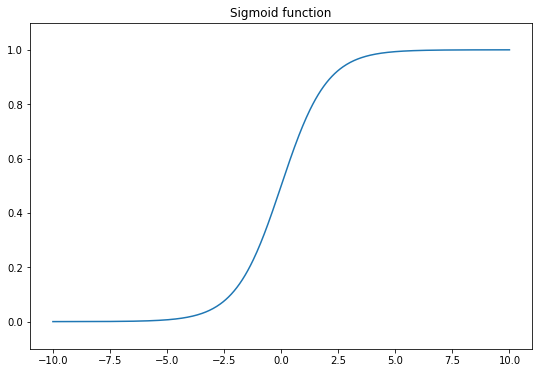

In [ ]:
x = tf.linspace(-10, 10, 500)
x = tf.cast(x, tf.float32)
f = lambda x : (1/20)*x + 0.6
plt.plot(x, tf.math.sigmoid(x))
plt.ylim((-0.1,1.1))
plt.title("Sigmoid function");

In [ ]:
def log_loss(y_pred, y):
 # Compute the log loss function
 ce = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_pred)
 return tf.reduce_mean(ce)

In [ ]:
class LogisticRegression(tf.Module):
  def __init__(self):
    self.built = False
  def __call__(self, x, train=True):
# Initialize the model parameters on the first call
    if not self.built:
    # Randomly generate the weights and the bias term
      rand_w = tf.random.uniform(shape=[x.shape[-1], 1], seed=22)
      rand_b = tf.random.uniform(shape=[], seed=22)
      self.w = tf.Variable(rand_w)
      self.b = tf.Variable(rand_b)
      self.built = True
    # Compute the model output
      z = tf.add(tf.matmul(x, self.w), self.b)
      z = tf.squeeze(z, axis=1)
    if train:
      return z
    return tf.sigmoid(z)

log_reg = LogisticRegression()
y_pred = log_reg(x_train_norm[:5], train=False)
y_pred.numpy()


NameError: ignored

In [ ]:
def predict_class(y_pred, thresh=0.5):
  # Return a tensor with `1` if `y_pred` > `0.5`, and `0` otherwise
  return tf.cast(y_pred > thresh, tf.float32)
def accuracy(y_pred, y):
  # Return the proportion of matches between `y_pred` and `y`
  y_pred = tf.math.sigmoid(y_pred)
  y_pred_class = predict_class(y_pred)
  check_equal = tf.cast(y_pred_class == y,tf.float32)
  acc_val = tf.reduce_mean(check_equal)
  return acc_val

In [ ]:
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_norm, y_train))
train_dataset = train_dataset.shuffle(buffer_size=x_train.shape[0]).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_norm, y_test))
test_dataset = test_dataset.shuffle(buffer_size=x_test.shape[0]).batch(batch_size)

NameError: ignored